# Exploratory Data Analysis
This notebook serves to load, clean and explore two datasets (weather & air quality) so as to predict Daily Solar Panel Efficiency

## Importing the data

### Dataset obtained from: 
1. https://techassessment.blob.core.windows.net/aiap18-assessment-data/weather.db
2. https://techassessment.blob.core.windows.net/aiap18-assessment-data/air_quality.db

In [ ]:
#Access database

import sqlite3, pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


pd.set_option('display.max_columns', None)  


weather_db = r"data/weather.db"
conn = None
try:
    conn = sqlite3.connect(weather_db)
except sqlite3.Error as e:
    display(e)

In [4]:
#Find the Table Name in the database
query = '''
    SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
    '''
tables = pd.read_sql_query(query, conn)
tables

,name
0,weather


In [5]:
#Load the data into a dataframe
query = '''
    SELECT * FROM weather
    '''
w_df = pd.read_sql_query(query, conn)

In [6]:
# Check if data has been loaded correctly
w_df.shape

(3517, 18)

In [7]:
#Do the same for the air quality database
air_quality_db = r"data/air_quality.db"
conn = None
try:
    conn = sqlite3.connect(air_quality_db)
except sqlite3.Error as e:
    display(e)

#Load the data into a dataframe assuming the table is named the same as the database
query = '''
    SELECT * FROM air_quality
    '''
aq_df = pd.read_sql_query(query, conn)

In [8]:
# Check if data has been loaded correctly
aq_df.shape

(3875, 12)

## Exploring the data

In [9]:
w_df.head()

,data_ref,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency
0,4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea,01/04/2014,-,2,2,2,28.4,32.4,7.5,25.9,8.07,18.0,-59.3,100.0,1006,VH,W,High
1,c9d3c825-fd94-4e61-a4bc-2cf0f2208de0,02/04/2014,0,0,0,--,28.8,32.6,--,33.1,7.57,23.0,59.2,100.0,1005,Very High,S,Medium
2,6d445ffb-d4c2-4f94-a27e-224fabe46d10,03/04/2014,0,0,0,0,29.3,--,--,43.2,6.72,16.0,59.7,98.5,1005,Low,E,Medium
3,7a404c50-710f-451a-9a42-a66bb783a3d0,04/04/2014,0,0,0,0,28.6,32.4,7.4,33.1,7.55,20.0,59.1,100.0,1011,Very High,W,Medium
4,0d3194a7-ad1a-456e-9bf8-b1bae730977b,05/04/2014,23.4,15.2,17.2,17.4,26.4,28,5.4,28.1,5.27,74.0,58.9,100.0,1012,Very High,east,Low


In [10]:
aq_df.head()

,data_ref,date,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
0,4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea,01/04/2014,20,16,18,23,19,58,56,57,66,59
1,c9d3c825-fd94-4e61-a4bc-2cf0f2208de0,02/04/2014,18,14,-,22,16,57,53,54,61,56
2,6d445ffb-d4c2-4f94-a27e-224fabe46d10,03/04/2014,12,12,10,14,10,55,53,52,59,54
3,7a404c50-710f-451a-9a42-a66bb783a3d0,04/04/2014,--,-,24,19,25,58,57,55,-,56
4,0d3194a7-ad1a-456e-9bf8-b1bae730977b,05/04/2014,18,19,21,13,17,64,64,66,-,66


In [11]:
#Convert the dates into the right formats so as to sort them to view the time period they span
pd.to_datetime(w_df.date, dayfirst = True).sort_values()

0      2014-04-01
1      2014-04-02
2      2014-04-03
3      2014-04-04
4      2014-04-05
          ...    
3192   2022-12-27
3193   2022-12-28
3194   2022-12-29
3195   2022-12-30
3196   2022-12-31
Name: date, Length: 3517, dtype: datetime64[ns]

In [12]:
pd.to_datetime(aq_df.date, dayfirst = True).sort_values()

0      2014-04-01
1      2014-04-02
2      2014-04-03
3      2014-04-04
4      2014-04-05
          ...    
3153   2022-12-27
3154   2022-12-28
3155   2022-12-29
3156   2022-12-30
3157   2022-12-31
Name: date, Length: 3875, dtype: datetime64[ns]

#### Initial impressions
1. Looks like either the data_ref or date column can be used to match both datasets chronologically. I.e. data_ref is the same for both datasets for the same date.

2. The airquality dataset is fully numeric but the weather dataset has some categorical variables.

3. The outcome variable "Daily Solar Panel Efficiency" is in the weather dataset

4. Both datasets span from Apr 2014 to Dec 2022

In [13]:
#Checking for datatype and nulls
w_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3517 entries, 0 to 3516
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   data_ref                       3517 non-null   object 
 1   date                           3517 non-null   object 
 2   Daily Rainfall Total (mm)      3517 non-null   object 
 3   Highest 30 Min Rainfall (mm)   3517 non-null   object 
 4   Highest 60 Min Rainfall (mm)   3517 non-null   object 
 5   Highest 120 Min Rainfall (mm)  3517 non-null   object 
 6   Min Temperature (deg C)        3517 non-null   object 
 7   Maximum Temperature (deg C)    3517 non-null   object 
 8   Min Wind Speed (km/h)          3517 non-null   object 
 9   Max Wind Speed (km/h)          3502 non-null   object 
 10  Sunshine Duration (hrs)        3501 non-null   float64
 11  Cloud Cover (%)                3501 non-null   float64
 12  Wet Bulb Temperature (deg F)   3517 non-null   f

In [14]:
aq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3875 entries, 0 to 3874
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   data_ref      3875 non-null   object
 1   date          3875 non-null   object
 2   pm25_north    3836 non-null   object
 3   pm25_south    3836 non-null   object
 4   pm25_east     3836 non-null   object
 5   pm25_west     3836 non-null   object
 6   pm25_central  3836 non-null   object
 7   psi_north     3836 non-null   object
 8   psi_south     3836 non-null   object
 9   psi_east      3836 non-null   object
 10  psi_west      3836 non-null   object
 11  psi_central   3836 non-null   object
dtypes: object(12)
memory usage: 363.4+ KB


#### **Findings**
1. Looks like there are null values in each of the 3 columns in the weather dataset - Max Wind Speed (km/h), Sunshine Duration, Cloud Cover
2. And there are some records with null values in the airquality dataset as well
3. Will have to change the datatypes of these columns as well

#### Course of action
1. Check for duplicates in both datasets
2. Combine the 2 datasets into 1
3. Change the datatypes in the dataset accordingly
4. Check for missing values and handle them accordingly depending on the number of missing values for each record


## Cleaning the data

### Identify duplicates

**Intent**: I intend to check for duplicates using the data_ref and date columns

In [15]:
clean_w_df = w_df.copy()
clean_aq_df = aq_df.copy()

In [16]:
clean_w_df['data_ref'].duplicated().sum()

320

In [17]:
#check what the differences between the duplicate rows are
w_duplicates_id = clean_w_df['data_ref'][clean_w_df['data_ref'].duplicated()]
w_duplicates = clean_w_df[clean_w_df['data_ref'].isin(w_duplicates_id)]
w_duplicates = w_duplicates.sort_values(by = 'data_ref')
w_duplicates.head(6)

,data_ref,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency
3309,00b17e97-c76f-49ab-9e86-43272c7b2cfc,05/02/2017,23.4,22.2,23.4,23.4,26.9,32.4,7.2,34.9,5.03,64.0,58.9,100.0,1004,Normal,W,Low
1041,00b17e97-c76f-49ab-9e86-43272c7b2cfc,05/02/2017,23.4,22.2,23.4,23.4,26.9,32.4,7.2,34.9,5.03,64.0,58.9,100.0,1004,Normal,W,Low
2869,0137f7e1-e272-4ca8-ba01-b37cad39e841,07/02/2022,0.8,--,0.6,-,26.5,30.1,7.6,31.5,7.40,14.0,58.2,91.6,1013,high,N,Medium
3365,0137f7e1-e272-4ca8-ba01-b37cad39e841,07/02/2022,0.8,--,0.6,-,26.5,30.1,7.6,31.5,7.40,14.0,58.2,91.6,1013,high,N,Medium
3392,01717757-add7-46f9-a904-cb6e3abbd4e6,21/12/2019,3.9,3.9,-,3.9,-,30.9,--,31.7,7.15,31.0,58.9,100.0,1007,Very High,NW,Medium
2090,01717757-add7-46f9-a904-cb6e3abbd4e6,21/12/2019,3.9,3.9,-,3.9,-,30.9,--,31.7,7.15,31.0,58.9,100.0,1007,Very High,NW,Medium


**Findings**: Looks like the duplicate data_ref records have exactly the same values in the other columns. I.e. the record is exactly the same

**Intent**: Remove the duplicates

In [18]:
#Remove the duplicates
clean_w_df = clean_w_df[~clean_w_df['data_ref'].isin(w_duplicates_id)]
display(clean_w_df['data_ref'].duplicated().sum()) #check if it has been implemented correctly


0

**Intent**: Do the same for the airquality dataset

In [19]:
clean_aq_df['data_ref'].duplicated().sum()

678

In [20]:
#check what the differences between the duplicate rows are
aq_duplicates_id = clean_aq_df['data_ref'][clean_aq_df['data_ref'].duplicated()]
aq_duplicates = clean_aq_df[clean_aq_df['data_ref'].isin(aq_duplicates_id)]
aq_duplicates = aq_duplicates.sort_values(by = 'data_ref')
aq_duplicates.head(6)

,data_ref,date,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
3376,0110ac6f-9616-4d03-9cbe-7f42f9f462e5,22/12/2015,15,21,28,22,22,54,57,62,62,--
621,0110ac6f-9616-4d03-9cbe-7f42f9f462e5,22/12/2015,15,21,28,22,22,54,57,62,62,--
3178,0137f7e1-e272-4ca8-ba01-b37cad39e841,07/02/2022,9,7,8,6,10,38,32,37,-,42
2834,0137f7e1-e272-4ca8-ba01-b37cad39e841,07/02/2022,9,7,8,6,10,38,32,37,-,42
3737,01717757-add7-46f9-a904-cb6e3abbd4e6,21/12/2019,7,9,8,5,--,33,41,35,36,41
2061,01717757-add7-46f9-a904-cb6e3abbd4e6,21/12/2019,7,9,8,5,--,33,41,35,36,41


**Findings**: Looks like the duplicates have exactly the same records

**Intent**: Remove the duplicates

In [21]:
#Remove the duplicates
clean_aq_df = clean_aq_df[~clean_aq_df['data_ref'].isin(aq_duplicates_id)]
display(clean_aq_df['data_ref'].duplicated().sum()) #check if it has been implemented correctly


0

**Intent**: Check if there are still duplicates in the date column for both datasets

In [22]:
clean_w_df['date'].duplicated().sum()

0

In [23]:
clean_aq_df['date'].duplicated().sum()

0

**Findings**: Looks like there are no repeated dates

### Combine the 2 datasets together

**Intent**: Check to see if the size of the two datasets are comparable

In [24]:
display(f"Shape of the weather df: {clean_w_df.shape}")
display(f"Shape of the air quality df: {clean_aq_df.shape}")

'Shape of the weather df: (2897, 18)'

'Shape of the air quality df: (2589, 12)'

**Findings**: Luckily they have similar number of records. Since the number of records do not differ by much (~10%), we will combine the two datasets together using an inner join.

In [25]:
# Merging the 2 datasets together using records with dates which exist in both datasets.
df = clean_w_df.merge(right = clean_aq_df.drop(columns = 'date'),how = 'inner', on = 'data_ref')
df.shape

(2342, 28)

In [26]:
#Dropping the data_ref column since both datasets have been merged and it's no longer necessary. We will use dates as the unique identifier
df = df.drop(columns = 'data_ref')
df.head()

,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
0,01/04/2014,-,2,2,2,28.4,32.4,7.5,25.9,8.07,18.0,-59.3,100.0,1006,VH,W,High,20,16,18,23,19,58,56,57,66,59
1,02/04/2014,0,0,0,--,28.8,32.6,--,33.1,7.57,23.0,59.2,100.0,1005,Very High,S,Medium,18,14,-,22,16,57,53,54,61,56
2,03/04/2014,0,0,0,0,29.3,--,--,43.2,6.72,16.0,59.7,98.5,1005,Low,E,Medium,12,12,10,14,10,55,53,52,59,54
3,04/04/2014,0,0,0,0,28.6,32.4,7.4,33.1,7.55,20.0,59.1,100.0,1011,Very High,W,Medium,--,-,24,19,25,58,57,55,-,56
4,05/04/2014,23.4,15.2,17.2,17.4,26.4,28,5.4,28.1,5.27,74.0,58.9,100.0,1012,Very High,east,Low,18,19,21,13,17,64,64,66,-,66


### Change the datatypes and clean the data

**Intent**:
1. Change date column to the datetime format
2. Change numeric columns to a numeric format
3. Encode categorical predictor columns

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2342 entries, 0 to 2341
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           2342 non-null   object 
 1   Daily Rainfall Total (mm)      2342 non-null   object 
 2   Highest 30 Min Rainfall (mm)   2342 non-null   object 
 3   Highest 60 Min Rainfall (mm)   2342 non-null   object 
 4   Highest 120 Min Rainfall (mm)  2342 non-null   object 
 5   Min Temperature (deg C)        2342 non-null   object 
 6   Maximum Temperature (deg C)    2342 non-null   object 
 7   Min Wind Speed (km/h)          2342 non-null   object 
 8   Max Wind Speed (km/h)          2336 non-null   object 
 9   Sunshine Duration (hrs)        2335 non-null   float64
 10  Cloud Cover (%)                2335 non-null   float64
 11  Wet Bulb Temperature (deg F)   2342 non-null   float64
 12  Relative Humidity (%)          2342 non-null   f

In [28]:
# Specifying the categorical and numerical columns
cat_columns = ['Dew Point Category','Wind Direction','Daily Solar Panel Efficiency']
display(f"categorical columns: {cat_columns}")
num_columns = [x for x in df.columns[1:] if x not in cat_columns]
display(f"numeric columns: {num_columns}")


"categorical columns: ['Dew Point Category', 'Wind Direction', 'Daily Solar Panel Efficiency']"

"numeric columns: ['Daily Rainfall Total (mm)', 'Highest 30 Min Rainfall (mm)', 'Highest 60 Min Rainfall (mm)', 'Highest 120 Min Rainfall (mm)', 'Min Temperature (deg C)', 'Maximum Temperature (deg C)', 'Min Wind Speed (km/h)', 'Max Wind Speed (km/h)', 'Sunshine Duration (hrs)', 'Cloud Cover (%)', 'Wet Bulb Temperature (deg F)', 'Relative Humidity (%)', 'Air Pressure (hPa)', 'pm25_north', 'pm25_south', 'pm25_east', 'pm25_west', 'pm25_central', 'psi_north', 'psi_south', 'psi_east', 'psi_west', 'psi_central']"

#### Date

In [29]:
# Changing the date column to the datetime format
df['date'] = pd.to_datetime(df.date, dayfirst= True)

In [30]:
# Checking to see if there were any issues with the conversion
df.date.info()

<class 'pandas.core.series.Series'>
Int64Index: 2342 entries, 0 to 2341
Series name: date
Non-Null Count  Dtype         
--------------  -----         
2342 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 36.6 KB


#### Numerical variables

In [31]:
df.head()

,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
0,2014-04-01,-,2,2,2,28.4,32.4,7.5,25.9,8.07,18.0,-59.3,100.0,1006,VH,W,High,20,16,18,23,19,58,56,57,66,59
1,2014-04-02,0,0,0,--,28.8,32.6,--,33.1,7.57,23.0,59.2,100.0,1005,Very High,S,Medium,18,14,-,22,16,57,53,54,61,56
2,2014-04-03,0,0,0,0,29.3,--,--,43.2,6.72,16.0,59.7,98.5,1005,Low,E,Medium,12,12,10,14,10,55,53,52,59,54
3,2014-04-04,0,0,0,0,28.6,32.4,7.4,33.1,7.55,20.0,59.1,100.0,1011,Very High,W,Medium,--,-,24,19,25,58,57,55,-,56
4,2014-04-05,23.4,15.2,17.2,17.4,26.4,28,5.4,28.1,5.27,74.0,58.9,100.0,1012,Very High,east,Low,18,19,21,13,17,64,64,66,-,66


**Findings**: Realised that there are missing records as '-' and '--'

**Intent**: I plan to coerce them into null values and impute values based on how many values are missing in each row

In [32]:
for x in num_columns:
    df[x] = pd.to_numeric(df[x], errors = 'coerce')
df

,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
0,2014-04-01,NaN,2.0,2.0,2.0,28.4,32.4,7.5,25.9,8.07,18.0,-59.3,100.0,1006,VH,W,High,20.0,16.0,18.0,23.0,19.0,58.0,56.0,57.0,66.0,59.0
1,2014-04-02,0.0,0.0,0.0,NaN,28.8,32.6,NaN,33.1,7.57,23.0,59.2,100.0,1005,Very High,S,Medium,18.0,14.0,NaN,22.0,16.0,57.0,53.0,54.0,61.0,56.0
2,2014-04-03,0.0,0.0,0.0,0.0,29.3,NaN,NaN,43.2,6.72,16.0,59.7,98.5,1005,Low,E,Medium,12.0,12.0,10.0,14.0,10.0,55.0,53.0,52.0,59.0,54.0
3,2014-04-04,0.0,0.0,0.0,0.0,28.6,32.4,7.4,33.1,7.55,20.0,59.1,100.0,1011,Very High,W,Medium,NaN,NaN,24.0,19.0,25.0,58.0,57.0,55.0,NaN,56.0
4,2014-04-05,23.4,15.2,17.2,17.4,26.4,28.0,5.4,28.1,5.27,74.0,58.9,100.0,1012,Very High,east,Low,18.0,19.0,21.0,13.0,17.0,64.0,64.0,66.0,NaN,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2337,2022-12-27,0.0,0.0,0.0,0.0,27.4,NaN,14.0,37.0,6.96,23.0,57.7,93.6,1006,HIGH,S,Medium,6.0,13.0,15.0,8.0,10.0,30.0,51.0,NaN,41.0,46.0
2338,2022-12-28,0.2,NaN,0.2,0.2,26.8,30.1,10.9,33.3,7.28,26.0,57.3,86.7,1008,High,SW.,Medium,7.0,NaN,15.0,7.0,11.0,31.0,52.0,NaN,30.0,42.0
2339,2022-12-29,15.8,NaN,11.4,15.8,26.3,30.3,10.4,NaN,5.74,45.0,57.3,100.0,1007,High,SE,Low,7.0,11.0,16.0,9.0,12.0,31.0,51.0,56.0,36.0,45.0
2340,2022-12-30,0.0,0.0,0.0,0.0,27.2,31.1,10.5,33.3,7.40,18.0,-57.0,91.7,1005,High,NW,Medium,NaN,14.0,16.0,9.0,13.0,30.0,52.0,55.0,35.0,49.0


In [33]:
df.describe()

,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
count,2119.000000,2116.000000,2119.000000,2106.000000,2105.000000,2113.000000,2108.000000,2110.000000,2335.000000,2335.000000,2342.000000,2342.000000,2342.000000,2109.000000,2117.000000,2118.000000,2110.000000,2104.000000,2103.000000,2117.000000,2120.000000,2103.000000,2116.000000
mean,5.235913,3.150284,3.816045,4.448433,28.085178,31.735542,8.744782,29.937867,7.021293,28.746895,53.001537,97.392442,1008.691716,14.899241,14.650213,14.505666,13.685071,14.143061,51.705896,50.500236,50.675472,48.326676,50.033790
std,12.300155,6.674165,8.305919,9.773996,1.080412,1.482349,2.935202,14.513422,1.404491,20.965567,25.785327,4.968925,3.479078,10.938413,12.731602,11.378851,12.695881,9.623387,15.975560,17.172086,15.663292,18.498908,14.731832
min,0.000000,0.000000,0.000000,0.000000,23.400000,24.600000,0.400000,-59.800000,0.000000,2.000000,-60.700000,70.700000,998.000000,4.000000,4.000000,3.000000,2.000000,3.000000,18.000000,20.000000,17.000000,16.000000,19.000000
25%,0.000000,0.000000,0.000000,0.000000,27.400000,31.000000,6.500000,27.800000,6.720000,17.000000,58.400000,96.700000,1006.000000,10.000000,9.000000,9.000000,8.000000,9.000000,43.000000,41.000000,42.000000,37.000000,41.000000
50%,0.000000,0.000000,0.000000,0.000000,28.200000,32.000000,8.100000,31.500000,7.420000,22.000000,58.900000,100.000000,1009.000000,13.000000,12.000000,12.000000,11.000000,12.000000,52.000000,52.000000,52.000000,49.000000,52.000000
75%,4.000000,2.600000,3.000000,3.400000,28.900000,32.700000,10.800000,35.600000,7.850000,30.000000,59.400000,100.000000,1011.000000,17.000000,16.000000,16.000000,16.000000,16.000000,58.000000,56.000000,56.000000,56.000000,56.000000
max,204.000000,49.800000,69.800000,85.600000,30.700000,35.000000,18.800000,64.800000,9.150000,100.000000,61.800000,100.000000,1020.000000,199.000000,235.000000,176.000000,197.000000,176.000000,265.000000,288.000000,253.000000,276.000000,238.000000


**Findings**: 
1. Interestingly the minimum max wind speed is negative which is not possible
2. And the distribution of the wet bulb temperature is strange, especially with a negative minimum value when the min temperature is only 23 degrees celsius

**Intent**: Check the histograms of both features and determine the next course of action

##### Max Wind Speed

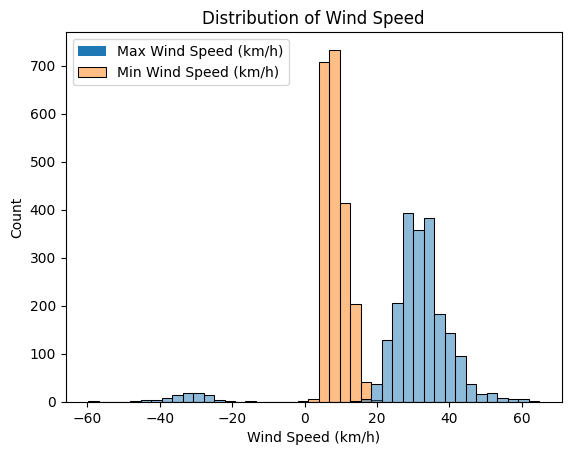

In [34]:
#Plotting the histogram of the Max and Min Wind Speed columns
sns.histplot(df[['Max Wind Speed (km/h)','Min Wind Speed (km/h)']])
plt.xlabel('Wind Speed (km/h)')
plt.ylabel('Count')
plt.title('Distribution of Wind Speed')
plt.legend(['Max Wind Speed (km/h)','Min Wind Speed (km/h)'])
plt.show()

**Findings**: Given that the Min Wind Speed range from 0 to 30, and the Max Wind Speed ranges from 10 to 60, the values below 0 for Max Wind Speed looks like might have been recorded as negative instead of positive wrongly.

**Intent**: Take the absolute values

In [35]:
df['Max Wind Speed (km/h)'] = abs(df['Max Wind Speed (km/h)'])
df['Max Wind Speed (km/h)'].describe()

count    2110.000000
mean       32.607251
std         6.603281
min        14.800000
25%        28.100000
50%        31.700000
75%        36.000000
max        64.800000
Name: Max Wind Speed (km/h), dtype: float64

##### Wet Bulb Temperature

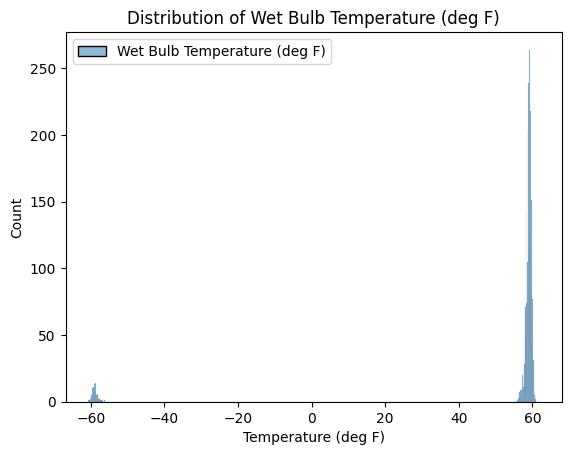

In [36]:
#Plotting the histogram of the Max and Min Wind Speed columns
sns.histplot(df[['Wet Bulb Temperature (deg F)']])
plt.xlabel('Temperature (deg F)')
plt.ylabel('Count')
plt.title('Distribution of Wet Bulb Temperature (deg F)')
plt.show()

**Findings**: Looks like some of the values might have been recorded as negative instead of positive wrongly.

**Intent**: Take the absolute values

In [37]:
df['Wet Bulb Temperature (deg F)'] = abs(df['Wet Bulb Temperature (deg F)'])
df['Wet Bulb Temperature (deg F)'].describe()

count    2342.000000
mean       58.933988
std         0.739880
min        55.300000
25%        58.500000
50%        59.000000
75%        59.400000
max        61.800000
Name: Wet Bulb Temperature (deg F), dtype: float64

##### Null values

**Intent**: Let's see how many records have null values and which columns have null values

In [38]:
df_null = df[df.isnull().any(axis = 1)]
print(f'Number of null records: {len(df_null)}')
cols_with_nulls = df.loc[:,df.isnull().any(axis = 0)].columns
print(f'Columns with nulls: {cols_with_nulls}')

Number of null records: 1990
Columns with nulls: Index(['Daily Rainfall Total (mm)', 'Highest 30 Min Rainfall (mm)',
       'Highest 60 Min Rainfall (mm)', 'Highest 120 Min Rainfall (mm)',
       'Min Temperature (deg C)', 'Maximum Temperature (deg C)',
       'Min Wind Speed (km/h)', 'Max Wind Speed (km/h)',
       'Sunshine Duration (hrs)', 'Cloud Cover (%)', 'pm25_north',
       'pm25_south', 'pm25_east', 'pm25_west', 'pm25_central', 'psi_north',
       'psi_south', 'psi_east', 'psi_west', 'psi_central'],
      dtype='object')


**Findings**: 
1. 1990 records is too many to remove, we will need to find a way to interpolate the data
2. There are no null values in the categorical columns

**Intent**: Let's see how many missing fields there are for each record

<function matplotlib.pyplot.show(close=None, block=None)>

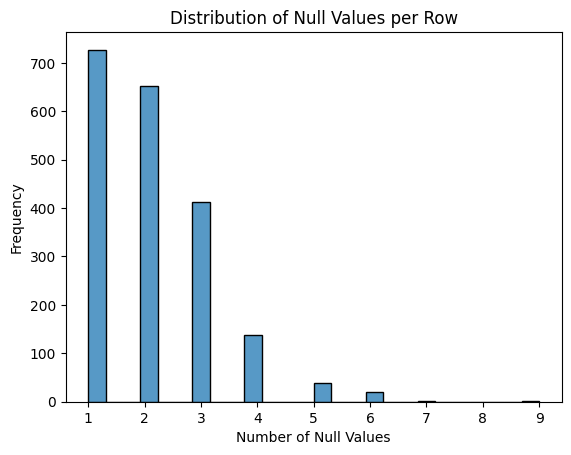

In [39]:
sns.histplot(df_null.isnull().sum(axis = 1), kde=False)
plt.xlabel("Number of Null Values")
plt.ylabel("Frequency")
plt.title("Distribution of Null Values per Row")
plt.show

**Findings**: Given that we have 2342 records, I plan to impute the missing data for rows with 4 or less missing fields using regression imputation\
I.e. using the other columns to estimate the missing value\
This would mean forgoing about 100 or so rows with 5 or more columns with missing fields.\
Taking the median or mean for each feature doesn't work for me since there will be days when it rains and when it doesn't rain and the values will be different depending on what type of day it is. Imputing a value based on the other features in the same record makes more sense to me.

In [40]:
# Number of rows with 4 or less missing fields
print(f'Number of null records with 4 or less missing fields: {len(df_null[df_null.isnull().sum(axis = 1) < 5])}')
# Number of rows with 5 or more missing fields
print(f'Number of null records with 5 or more missing fields: {len(df_null[df_null.isnull().sum(axis = 1) >= 5])}')

Number of null records with 4 or less missing fields: 1928
Number of null records with 5 or more missing fields: 62


In [41]:
# remove rows with 5 or more columns with missing fields
df = df[df.isnull().sum(axis = 1) < 5]

# fit regression model using Bayesian Ridge
imputer = IterativeImputer(estimator=BayesianRidge())

# impute missing values
imputed_data = imputer.fit_transform(df[num_columns])

# substitute imputed values for missing values
df[num_columns] = imputed_data


C:\Users\User\AppData\Local\Temp\ipykernel_24556\2794664494.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_columns] = imputed_data


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2280 entries, 0 to 2341
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           2280 non-null   datetime64[ns]
 1   Daily Rainfall Total (mm)      2280 non-null   float64       
 2   Highest 30 Min Rainfall (mm)   2280 non-null   float64       
 3   Highest 60 Min Rainfall (mm)   2280 non-null   float64       
 4   Highest 120 Min Rainfall (mm)  2280 non-null   float64       
 5   Min Temperature (deg C)        2280 non-null   float64       
 6   Maximum Temperature (deg C)    2280 non-null   float64       
 7   Min Wind Speed (km/h)          2280 non-null   float64       
 8   Max Wind Speed (km/h)          2280 non-null   float64       
 9   Sunshine Duration (hrs)        2280 non-null   float64       
 10  Cloud Cover (%)                2280 non-null   float64       
 11  Wet Bulb Temperat

In [43]:
df.head()

,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
0,2014-04-01,1.843191,2.0,2.0,2.000000,28.4,32.400000,7.500000,25.9,8.07,18.0,59.3,100.0,1006.0,VH,W,High,20.000000,16.00000,18.000000,23.0,19.0,58.0,56.0,57.0,66.000000,59.0
1,2014-04-02,0.000000,0.0,0.0,0.063852,28.8,32.600000,9.381800,33.1,7.57,23.0,59.2,100.0,1005.0,Very High,S,Medium,18.000000,14.00000,15.084929,22.0,16.0,57.0,53.0,54.0,61.000000,56.0
2,2014-04-03,0.000000,0.0,0.0,0.000000,29.3,33.113938,11.423662,43.2,6.72,16.0,59.7,98.5,1005.0,Low,E,Medium,12.000000,12.00000,10.000000,14.0,10.0,55.0,53.0,52.0,59.000000,54.0
3,2014-04-04,0.000000,0.0,0.0,0.000000,28.6,32.400000,7.400000,33.1,7.55,20.0,59.1,100.0,1011.0,Very High,W,Medium,23.980828,26.07129,24.000000,19.0,25.0,58.0,57.0,55.0,49.481244,56.0
4,2014-04-05,23.400000,15.2,17.2,17.400000,26.4,28.000000,5.400000,28.1,5.27,74.0,58.9,100.0,1012.0,Very High,east,Low,18.000000,19.00000,21.000000,13.0,17.0,64.0,64.0,66.0,55.706333,66.0


In [44]:
# Dataframe showing where the null values were previously
df_null.isnull().replace(False,'-').head()

,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
0,-,True,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
1,-,-,-,-,True,-,-,True,-,-,-,-,-,-,-,-,-,-,-,True,-,-,-,-,-,-,-
2,-,-,-,-,-,-,True,True,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
3,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,True,True,-,-,-,-,-,-,True,-
4,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,True,-


**Findings**: We can observe that for certain columns, some of the imputed values are a little erroneous. For example, on 1 April 2014, total daily rainfall has to be at least 2mm based on the other highest rainfall categories. But the imputed value is 1.84.

In [45]:
df.describe()

,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
count,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.00000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000
mean,5.250533,3.085590,3.828983,4.355036,28.088668,31.721541,8.745729,32.528966,7.027728,28.618974,58.935482,97.385658,1008.696930,15.031254,14.658877,14.444142,13.66388,14.197755,51.509107,50.717478,50.694034,48.162206,50.183579
std,12.324246,6.594713,8.452486,9.692666,1.072204,1.479720,2.854243,6.605267,1.406702,20.878084,0.739199,4.964721,3.481763,11.232530,12.706034,11.173855,12.67117,10.034866,15.588957,17.101806,15.726855,18.171023,14.613835
min,-2.530483,-0.319392,-0.250389,-0.436721,23.400000,23.395237,0.400000,14.800000,0.000000,2.000000,55.300000,70.700000,998.000000,4.000000,1.970516,2.721629,0.85985,3.000000,18.000000,20.000000,17.000000,16.000000,19.000000
25%,0.000000,0.000000,0.000000,0.000000,27.400000,31.000000,6.500000,28.100000,6.730000,17.000000,58.500000,96.700000,1006.000000,10.000000,9.000000,9.000000,8.00000,9.000000,43.000000,41.000000,42.000000,37.000000,41.348111
50%,0.000000,0.107212,0.005242,0.076146,28.200000,32.000000,8.300000,31.666918,7.430000,21.000000,59.000000,100.000000,1009.000000,13.000000,12.000000,12.000000,11.00000,12.000000,52.000000,52.000000,52.000000,49.000000,52.000000
75%,4.000000,2.400000,2.965542,3.200000,28.900000,32.700000,10.500000,35.600000,7.860000,29.250000,59.400000,100.000000,1011.000000,17.000000,16.043502,16.122388,16.00000,16.000000,57.012348,57.000000,56.000000,56.000000,56.000000
max,204.000000,49.800000,69.800000,85.600000,30.700000,35.000000,18.800000,64.800000,9.150000,100.000000,61.800000,100.000000,1020.000000,199.000000,235.000000,176.000000,197.00000,176.000000,265.000000,288.000000,253.000000,276.000000,238.000000


**Findings**: Futhermore, rainfall values cannot be negative.\
**Intent**: Will adjust for these implausible cases even if it means narrowing the variance of that column

##### Rainfall values cannot be negative

In [46]:
df[num_columns[:4]] = df[num_columns[:4]].clip(lower= 0)

C:\Users\User\AppData\Local\Temp\ipykernel_24556\2775419422.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_columns[:4]] = df[num_columns[:4]].clip(lower= 0)


##### Daily rainfall cannot be lower than the max of Highest 30min rainfall, 60min rainfall and 120min rainfall

In [47]:
def enforce_min_value(row):
  """Ensures a column's value is greater than or equal to the max of others."""

  cols_to_check = num_columns[1:4]  
  target_col = num_columns[0] 
  max_value = max(row[cols_to_check])
  row[target_col] = max(row[target_col], max_value)
  return row

# Apply the function to each row
df = df.apply(enforce_min_value, axis=1)

##### Let's now check the histogram of the numerical values

C:\Users\User\AppData\Local\Temp\ipykernel_24556\2637102294.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df[df.describe().columns].hist(ax=ax, color="b")


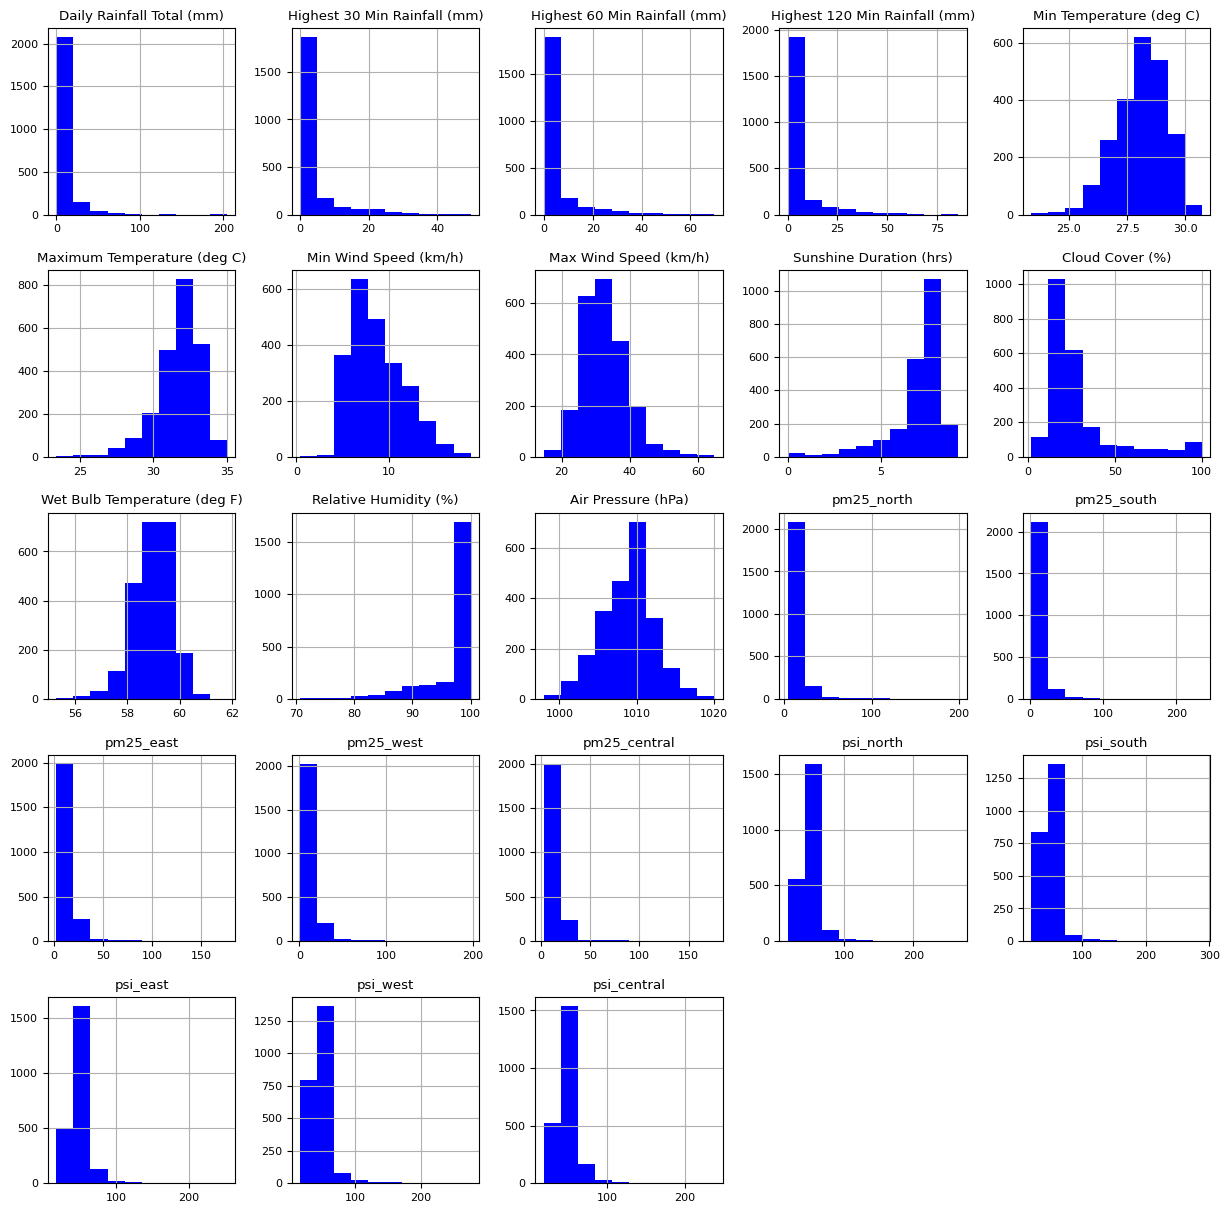

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
with plt.rc_context({'font.size': 8}): 
    df[df.describe().columns].hist(ax=ax, color="b")
plt.show()

**Findings**
- The histograms look more plausible now.
- On hindsight, all the values in the dataframe has to be positive.
- We can just ensure that all real values in the dataframe are positive by taking the absolute value.
- And change all imputed negative values to zero

#### Categorical variables

In [49]:
#Convert all values to uppercase
for x in cat_columns:
    df[x] = df[x].str.upper()

In [50]:
df[cat_columns].describe()

,Dew Point Category,Wind Direction,Daily Solar Panel Efficiency
count,2280,2280,2280
unique,15,25,3
top,HIGH,NW,MEDIUM
freq,950,261,1255


**Findings**: There are many labels for 'Dew Point Category' and 'Wind Direction'

In [51]:
# Check what the labels are for each feature and how they are distributed
for col in cat_columns:
    print(col,":", dict(Counter(df[col])))

Dew Point Category : {'VH': 53, 'VERY HIGH': 829, 'LOW': 83, 'HIGH': 950, 'MODERATE': 83, 'EXTREME': 54, 'VERY LOW': 87, 'HIGH LEVEL': 58, 'H': 60, 'M': 8, 'BELOW AVERAGE': 1, 'MINIMAL': 3, 'VL': 4, 'NORMAL': 6, 'L': 1}
Wind Direction : {'W': 244, 'S': 239, 'E': 211, 'EAST': 19, 'NORTHEAST': 43, 'NE': 220, 'SE': 248, 'NW': 261, 'SOUTHWARD': 12, 'W.': 12, 'SOUTHEAST': 69, 'SW': 256, 'N': 241, 'NORTHWARD': 18, 'NORTHWEST': 27, 'WEST': 30, 'NORTH': 15, 'SOUTH': 24, 'SE.': 15, 'SW.': 19, 'NE.': 13, 'S.': 7, 'NW.': 15, 'N.': 9, 'E.': 13}
Daily Solar Panel Efficiency : {'HIGH': 477, 'MEDIUM': 1255, 'LOW': 548}


**Findings**: 
1. There are many inconsistent labels for Dew Point Category and Wind Direction. 
2. The classes of Daily Solar Panel Efficiency are not distributed, it seems like a normal distribution with **Medium** Efficiency slightly higher than the sum of **Low** and **High** Efficiency

**Intent**: We will need to relabel some of these labels for Dew Point Category and Wind Direction

##### Dew Point Category

In [52]:
# Relabelling as best as possible. Have decided to relabel extreme as very high rather than very low.
df['Dew Point Category'] = df['Dew Point Category'].replace({'VH':'VERY HIGH','H': 'HIGH','M':'MODERATE','L':'LOW','VL':'VERY LOW','HIGH LEVEL': 'HIGH','MINIMAL': 'VERY LOW', 'BELOW AVERAGE':'LOW','NORMAL':'MODERATE','EXTREME':'VERY HIGH'})

In [53]:
# Checking the distribution of each Dew Point Label
Counter(df['Dew Point Category'])

Counter({'VERY HIGH': 936,
         'LOW': 85,
         'HIGH': 1068,
         'MODERATE': 97,
         'VERY LOW': 94})

##### Wind Direction

In [54]:
# Relabelling
df['Wind Direction'] = df['Wind Direction'].replace({'EAST':'E','NORTHEAST': 'NE','SOUTHWARD': 'S', 'SOUTHEAST':'S','NORTHWARD':'N','NORTHWEST':'NW','WEST':'W','NORTH':'N','SOUTH':'S'})
df['Wind Direction'] = df['Wind Direction'].str.replace('.','', regex = False)

In [55]:
# Checking on the number of each Wind Direction Label
Counter(df['Wind Direction'])

Counter({'W': 286,
         'S': 351,
         'E': 243,
         'NE': 276,
         'SE': 263,
         'NW': 303,
         'SW': 275,
         'N': 283})

**Intent**: Since there's an order to Dew Point Category and Daily Solar Panel Efficiency, we will use ordinal encoding for these 2 categories and Directional encoding for Wind Direction since it can be converted to angles

Ordinal encoding

In [56]:
df['Dew Point Category'] = df['Dew Point Category'].replace({'VERY HIGH': 5, 'HIGH': 4, 'MODERATE': 3, 'LOW': 2,'VERY LOW':1})

df['Daily Solar Panel Efficiency'] = df['Daily Solar Panel Efficiency'].replace({'HIGH':3,'MEDIUM':2,'LOW':1})

Directional encoding (Converting direction to angles in radians)

In [57]:
def direction_to_angle(direction):
  directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
  angles = np.linspace(0, 2*np.pi, len(directions), endpoint=False)
  return angles[directions.index(direction)]

#Encode Wind Direction
df['Wind Direction'] = df['Wind Direction'].apply(direction_to_angle)

In [58]:
df.head()

,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
0,2014-04-01,2.000000,2.0,2.0,2.000000,28.4,32.400000,7.500000,25.9,8.07,18.0,59.3,100.0,1006.0,5,4.712389,3,20.000000,16.00000,18.000000,23.0,19.0,58.0,56.0,57.0,66.000000,59.0
1,2014-04-02,0.063852,0.0,0.0,0.063852,28.8,32.600000,9.381800,33.1,7.57,23.0,59.2,100.0,1005.0,5,3.141593,2,18.000000,14.00000,15.084929,22.0,16.0,57.0,53.0,54.0,61.000000,56.0
2,2014-04-03,0.000000,0.0,0.0,0.000000,29.3,33.113938,11.423662,43.2,6.72,16.0,59.7,98.5,1005.0,2,1.570796,2,12.000000,12.00000,10.000000,14.0,10.0,55.0,53.0,52.0,59.000000,54.0
3,2014-04-04,0.000000,0.0,0.0,0.000000,28.6,32.400000,7.400000,33.1,7.55,20.0,59.1,100.0,1011.0,5,4.712389,2,23.980828,26.07129,24.000000,19.0,25.0,58.0,57.0,55.0,49.481244,56.0
4,2014-04-05,23.400000,15.2,17.2,17.400000,26.4,28.000000,5.400000,28.1,5.27,74.0,58.9,100.0,1012.0,5,1.570796,1,18.000000,19.00000,21.000000,13.0,17.0,64.0,64.0,66.0,55.706333,66.0


**Conclusion**:
1. The data looks cleaned!

## Feature selection

Given that Daily Solar Panel Efficiency is affected by the weather and air quality which have seasonal patterns, I will convert the date column into days from the start of the year to capture seasonal variations.

In [59]:
df.insert(0,'day_of_the_year',df['date'].dt.dayofyear.astype(int))
df.drop(columns='date', inplace = True)

### Correlation heatmap

Let's plot the correlation heatmap to check for any features with high correlation with one another.\
Reducing multicollinearity doesn't affect the predictions of the machine learning models used here but they would affect the efficiency of these models.

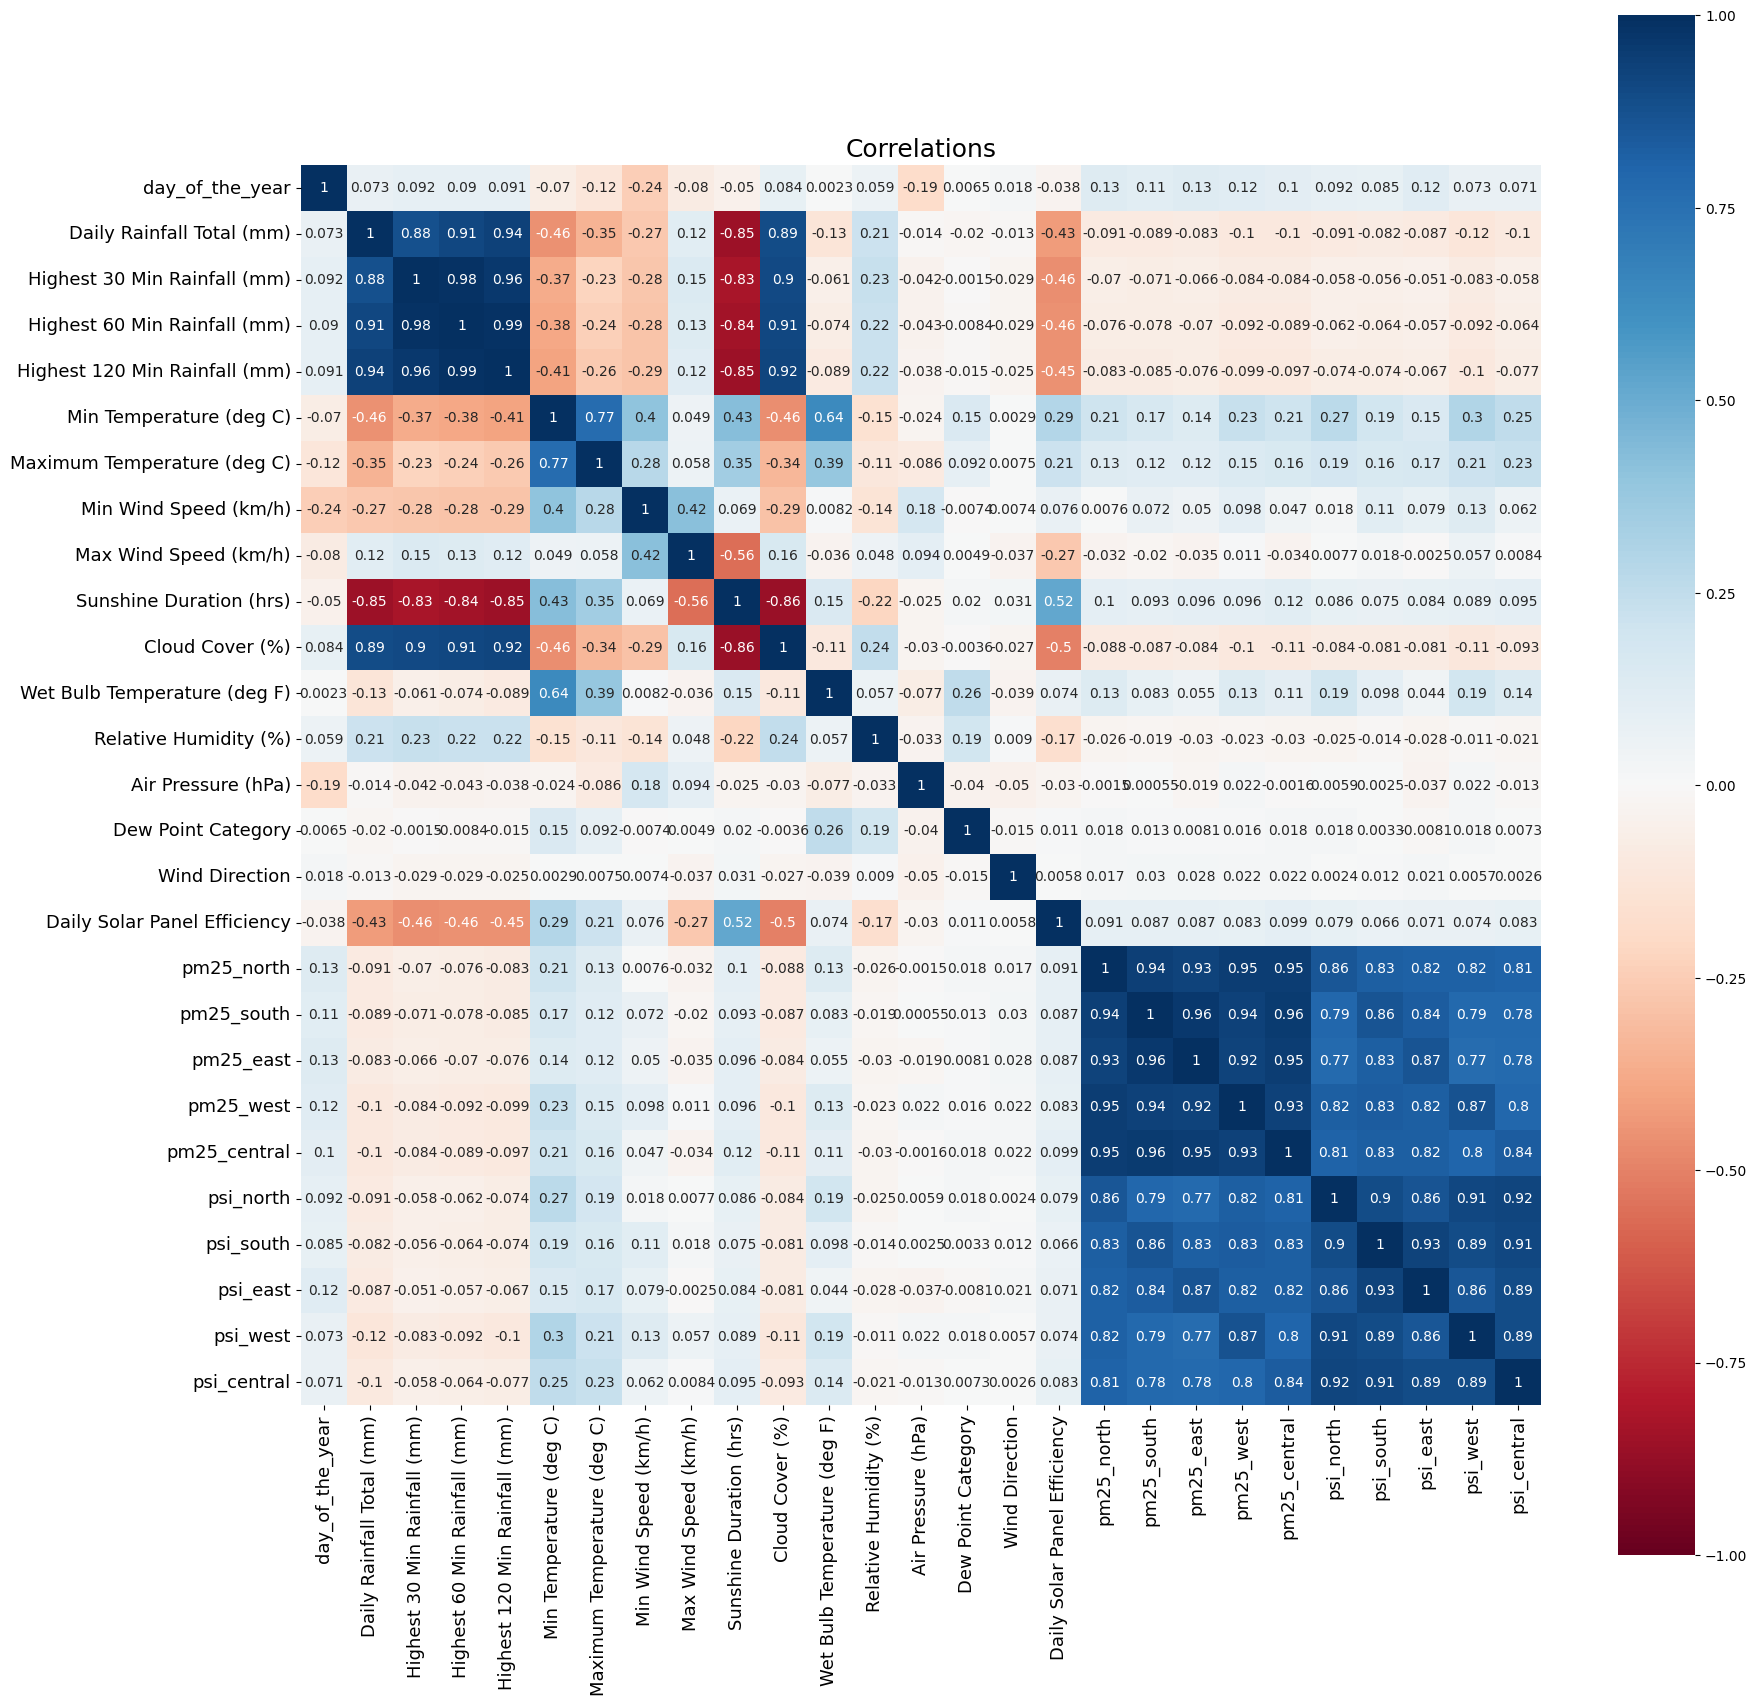

In [60]:
#Plot the correlation heatmap
plt.figure(figsize = (20,20))
sns.heatmap(df.corr(),annot=True,square=True,
            cmap='RdBu',
            vmax=1,
            vmin=-1)
plt.title('Correlations',size=18);
plt.xticks(size=13)
plt.yticks(size=13)
plt.show()

**Findings**: From here, we can see that there naturally is a high correlation between:
1. The various PM25 and PSI values
2. Cloud cover with the various rainfall measurements
3. Negative correlation between sunshine duration with cloud cover and the various rainfall measurements
4. High correlation between Daily Solar Panel Efficiency with cloud and the various rainfall measurements and a high negative correlation with cloud cover.

**Conclusion**:
1. Since we don't know where the solar panels are located, we will take the average of PM25 and PSI values to reduce the number of columns in the dataset
2. Since Sunshine duration seems to have the highest correlation with Daily Solar Panel Efficiency, we will drop the rainfall measurements and cloud cover from the dataset

In [61]:
# Take the average of PM25 and PSI values
pm25_and_psi_cols = ['pm25_north', 'pm25_south', 'pm25_east', 'pm25_west','pm25_central','psi_north', 'psi_south', 'psi_east', 'psi_west','psi_central']
df['pm25_and_psi'] = df[pm25_and_psi_cols].mean(axis = 1)
df = df.drop(columns = pm25_and_psi_cols)

# Drop rainfall measurements and cloud cover
df = df.drop(columns = ['Daily Rainfall Total (mm)', 
                        'Highest 30 Min Rainfall (mm)',
                        'Highest 60 Min Rainfall (mm)',
                        'Highest 120 Min Rainfall (mm)',
                        'Cloud Cover (%)'])

# Final clean dataset
df.head()

,day_of_the_year,Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency,pm25_and_psi
0,91,28.4,32.400000,7.500000,25.9,8.07,59.3,100.0,1006.0,5,4.712389,3,39.200000
1,92,28.8,32.600000,9.381800,33.1,7.57,59.2,100.0,1005.0,5,3.141593,2,36.608493
2,93,29.3,33.113938,11.423662,43.2,6.72,59.7,98.5,1005.0,2,1.570796,2,33.100000
3,94,28.6,32.400000,7.400000,33.1,7.55,59.1,100.0,1011.0,5,4.712389,2,39.353336
4,95,26.4,28.000000,5.400000,28.1,5.27,58.9,100.0,1012.0,5,1.570796,1,40.370633


### Screeplot

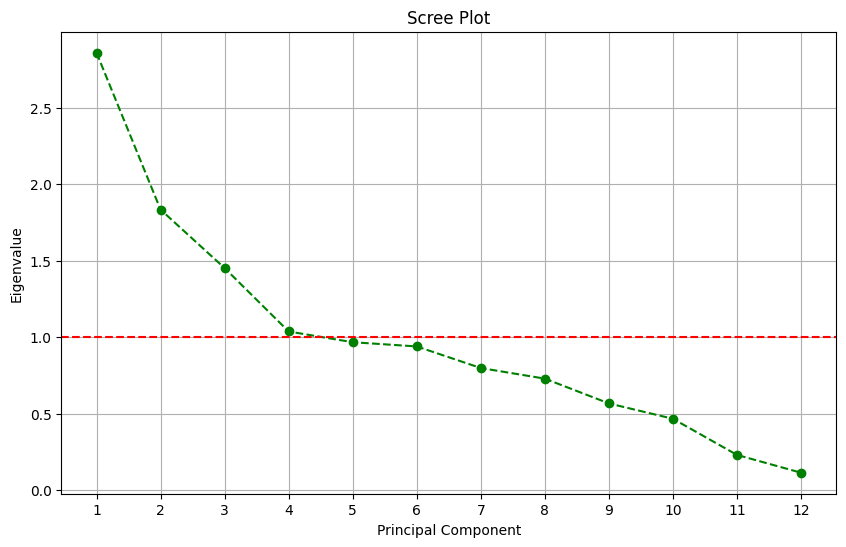

In [ ]:
### Screeplot to determine the n_components for PCA

scaler = StandardScaler()

outcome = ['Daily Solar Panel Efficiency']
predictor_columns = [x for x in df.columns[1:] if x != outcome]
X_scaled = scaler.fit_transform(df[predictor_columns])

pca = PCA()
pca.fit(X_scaled)

plt.figure(figsize=(10, 6))
components = np.arange(1, pca.n_components_ + 1)
eigenvalues = pca.explained_variance_

plt.plot(components, eigenvalues, marker='o', linestyle='--', color='green')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--')  # Cutoff line at eigenvalue = 1. Eigenvalues represent the amount of variance captured by each principal component. An eigenvalue greater than 1 indicates that the component explains more variance than a single original variable (which has a variance of 1). Therefore, retaining components with eigenvalues greater than 1 ensures that each selected component contributes more information than a single variable would
plt.xticks(components)
plt.grid()
plt.show()



## References

1. https://datasciencestunt.com/regression-imputation/